In [1]:
import dicom

import pandas as pd
import os
data_dir='E:/stage1/stage1_pre/'
patients=os.listdir(data_dir)
labels_df=pd.read_csv('C:/Users/anush/Desktop/PRO_LUNG/stage1_labels.csv/stage1_labels.csv',index_col=0)
labels_df.head()


,cancer
id,
0015ceb851d7251b8f399e39779d1e7d,1
0030a160d58723ff36d73f41b170ec21,0
003f41c78e6acfa92430a057ac0b306e,0
006b96310a37b36cccb2ab48d10b49a3,1
008464bb8521d09a42985dd8add3d0d2,1


In [2]:

import numpy as np
import dicom
import os
import matplotlib.pyplot as plt
from glob import glob
from mpl_toolkits.mplot3d.art3d import Poly3DCollection
import scipy.ndimage
from skimage import morphology
from skimage import measure
from skimage.transform import resize
from sklearn.cluster import KMeans
from plotly import __version__
from plotly.offline import download_plotlyjs, init_notebook_mode, plot, iplot
from plotly.tools import FigureFactory as FF
from plotly.graph_objs import *
init_notebook_mode(connected=True) 


###


# Print out the first 5 file names to verify we're in the right folder.
#print ("Total of %d DICOM images.\nFirst 5 filenames:" % len(g))
#print ('\n'.join(g[:5]))

###
IMG_PX_SIZE=150
def load_scan(path):
    print("load scan")
    slices = [dicom.read_file(path + '/' + s) for s in os.listdir(path)]
    slices.sort(key = lambda x: int(x.ImagePositionPatient[2]))
    #fig = plt.figure()
    #for num,each_slice in enumerate(slices[:12]):
       # y = fig.add_subplot(3,4,num+1)
       # new_img = cv2.resize(np.array(each_slice.pixel_array),(IMG_PX_SIZE,IMG_PX_SIZE))
       # y.imshow(new_img)
    #plt.show()

    try:
        slice_thickness = np.abs(slices[0].ImagePositionPatient[2] - slices[1].ImagePositionPatient[2])
    except:
        slice_thickness = np.abs(slices[0].SliceLocation - slices[1].SliceLocation)
        
    for s in slices:
        s.SliceThickness = slice_thickness
        
    return slices
import cv2
import numpy as np




def get_pixels_hu(scans):
    print("getting HU fields")
    image = np.stack([s.pixel_array for s in scans])
    # Convert to int16 (from sometimes int16), 
    # should be possible as values should always be low enough (<32k)
    image = image.astype(np.int16)

    # Set outside-of-scan pixels to 1
    # The intercept is usually -1024, so air is approximately 0
    image[image == -2000] = 0
    
    # Convert to Hounsfield units (HU)
    intercept = scans[0].RescaleIntercept
    slope = scans[0].RescaleSlope
    
    if slope != 1:
        image = slope * image.astype(np.float64)
        image = image.astype(np.int16)
        
    image += np.int16(intercept)
    
    return np.array(image, dtype=np.int16)


####

#########

#plt.hist(imgs.flatten(), bins=50, color='c')
#plt.xlabel("Hounsfield Units (HU)")
#plt.ylabel("Frequency")
#plt.show()
###########

###




####
#Standardize the pixel values
def make_lungmask(img, display=False):
    
    row_size= img.shape[0]
    col_size = img.shape[1]
    
    mean = np.mean(img)
    std = np.std(img)
    img = img-mean
    img = img/std
    # Find the average pixel value near the lungs
    # to renormalize washed out images
    middle = img[int(col_size/5):int(col_size/5*4),int(row_size/5):int(row_size/5*4)] 
    mean = np.mean(middle)  
    max = np.max(img)
    min = np.min(img)
    # To improve threshold finding, I'm moving the 
    # underflow and overflow on the pixel spectrum
    img[img==max]=mean
    img[img==min]=mean
    #
    # Using Kmeans to separate foreground (soft tissue / bone) and background (lung/air)
    #
    kmeans = KMeans(n_clusters=2).fit(np.reshape(middle,[np.prod(middle.shape),1]))
    centers = sorted(kmeans.cluster_centers_.flatten())
    threshold = np.mean(centers)
    thresh_img = np.where(img<threshold,1.0,0.0)  # threshold the image

    # First erode away the finer elements, then dilate to include some of the pixels surrounding the lung.  
    # We don't want to accidentally clip the lung.

    eroded = morphology.erosion(thresh_img,np.ones([3,3]))
    dilation = morphology.dilation(eroded,np.ones([8,8]))

    labels = measure.label(dilation) # Different labels are displayed in different colors
    label_vals = np.unique(labels)
    regions = measure.regionprops(labels)
    good_labels = []
    for prop in regions:
        B = prop.bbox
        if B[2]-B[0]<row_size/10*9 and B[3]-B[1]<col_size/10*9 and B[0]>row_size/5 and B[2]<col_size/5*4:
            good_labels.append(prop.label)
    mask = np.ndarray([row_size,col_size],dtype=np.int8)
    mask[:] = 0

    #
    #  After just the lungs are left, we do another large dilation
    #  in order to fill in and out the lung mask 
    #
    for N in good_labels:
        mask = mask + np.where(labels==N,1,0)
    mask = morphology.dilation(mask,np.ones([10,10])) # one last dilation

    if (display):
        fig, ax = plt.subplots(3, 2, figsize=[12, 12])
        ax[0, 0].set_title("Original")
        ax[0, 0].imshow(img, cmap='gray')
        ax[0, 0].axis('off')
        ax[0, 1].set_title("Threshold")
        ax[0, 1].imshow(thresh_img, cmap='gray')
        ax[0, 1].axis('off')
        ax[1, 0].set_title("After Erosion and Dilation")
        ax[1, 0].imshow(dilation, cmap='gray')
        ax[1, 0].axis('off')
        ax[1, 1].set_title("Color Labels")
        ax[1, 1].imshow(labels)
        ax[1, 1].axis('off')
        ax[2, 0].set_title("Final Mask")
        ax[2, 0].imshow(mask, cmap='gray')
        ax[2, 0].axis('off')
        ax[2, 1].set_title("Apply Mask on Original")
        ax[2, 1].imshow(mask*img, cmap='gray')
        ax[2, 1].axis('off')
        
        plt.show()
    return mask*img

####


In [3]:
def preprocess(num,data_path):
    patient = load_scan(data_path)
    imgs = get_pixels_hu(patient)
    masked_lung = []
    p=0
    for img in imgs:
        masked_lung.append(make_lungmask(img))
        if(p%30==0):
            print(p)
        p=p+1

    id=num
    
    np.save( "E:/stage1/test_prep/"+"finalimages_%d.npy" % (id), masked_lung)
    print("preprocessing of above completed" ,num)

    


In [4]:

###MAIN PREPROCESSING CODE
id=0
for patient in patients:
    path = data_dir + patient
    preprocess(id,path)
    id=id+1

load scan
getting HU fields
0
30
60
90
120
150
preprocessing of above completed 0
load scan
getting HU fields
0
30
60
90
120
150
180
210
preprocessing of above completed 1
load scan
getting HU fields
0
30
60
90
120
150
180
preprocessing of above completed 2
load scan
getting HU fields
0
30
60
90
120
150
180
210
240
270
300
preprocessing of above completed 3
load scan
getting HU fields
0
30
60
90
120
preprocessing of above completed 4
load scan
getting HU fields
0
30
60
90
120
preprocessing of above completed 5
load scan
getting HU fields
0
30
60
90
120
150
180
preprocessing of above completed 6
load scan
getting HU fields
0
30
60
90
120
150
180
210
240
270
300
330
360
390
preprocessing of above completed 7
load scan
getting HU fields
0
30
60
90
120
preprocessing of above completed 8
load scan
getting HU fields
0
30
60
90
120
150
preprocessing of above completed 9
load scan
getting HU fields
0
30
60
90
120
150
preprocessing of above completed 10
load scan
getting HU fields
0
30
60
90
12

getting HU fields
0
30
60
90
120
150
preprocessing of above completed 96
load scan
getting HU fields
0
30
60
90
120
150
180
210
preprocessing of above completed 97
load scan
getting HU fields
0
30
60
90
120
150
180
210
240
270
300
330
360
390
420
450
preprocessing of above completed 98
load scan
getting HU fields
0
30
60
90
120
150
preprocessing of above completed 99
load scan
getting HU fields
0
30
60
90
120
150
180
210
240
preprocessing of above completed 100
load scan
getting HU fields
0
30
60
90
120
preprocessing of above completed 101
load scan
getting HU fields
0
30
60
90
120
preprocessing of above completed 102
load scan
getting HU fields
0
30
60
90
120
preprocessing of above completed 103
load scan
getting HU fields
0
30
60
90
120
preprocessing of above completed 104
load scan
getting HU fields
0
30
60
90
120
150
preprocessing of above completed 105
load scan
getting HU fields
0
30
60
90
preprocessing of above completed 106
load scan
getting HU fields
0
30
60
90
120
preprocessi

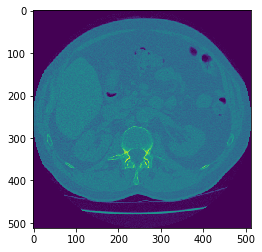

In [5]:
import matplotlib.pyplot as plt

for patient in patients[:1]:
    label = labels_df.get_value(patient, 'cancer')
    path = data_dir + patient
    slices = [dicom.read_file(path + '/' + s) for s in os.listdir(path)]
    slices.sort(key = lambda x: int(x.ImagePositionPatient[2]))
    
    #          the first slice
    plt.imshow(slices[0].pixel_array)
    plt.show()


In [6]:
id=0


In [12]:
import numpy as np
import pandas as pd
import dicom
import os
import matplotlib.pyplot as plt
import cv2
import math

IMG_SIZE_PX = 50
SLICE_COUNT = 20

def chunks(l, n):
    # Credit: Ned Batchelder
    # Link: http://stackoverflow.com/questions/312443/how-do-you-split-a-list-into-evenly-sized-chunks
    """Yield successive n-sized chunks from l."""
    for i in range(0, len(l), n):
        yield l[i:i + n]


def mean(a):
    return sum(a) / len(a)


def process_data(num,patient,labels_df,img_px_size=50, hm_slices=20, visualize=False):
    id=num
    label = labels_df.get_value(patient, 'cancer')
    path = data_dir + patient
    slices = [dicom.read_file(path + '/' + s) for s in os.listdir(path)]
    slices.sort(key = lambda x: int(x.ImagePositionPatient[2]))
    file_used= "E:/stage1/test_prep/"+"finalimages_%d.npy" % id
    imgs_to_process = np.load(file_used).astype(np.uint16) 

    for num,each_slice in enumerate(slices):
        #(each_slice.pixel_array)=copy(imgs_to_process[num])
        np.copyto(each_slice.pixel_array, imgs_to_process[num])
        #print(each_slice.pixel_array)
        #y.imshow(new_img,cmap='gray')

    

    

    new_slices = []
    slices = [cv2.resize(np.array(each_slice.pixel_array),(img_px_size,img_px_size)) for each_slice in slices]
    
    chunk_sizes = math.ceil(len(slices) / hm_slices)
    for slice_chunk in chunks(slices, chunk_sizes):
        slice_chunk = list(map(mean, zip(*slice_chunk)))
        new_slices.append(slice_chunk)

    if len(new_slices) == hm_slices-1:
        new_slices.append(new_slices[-1])

    if len(new_slices) == hm_slices-2:
        new_slices.append(new_slices[-1])
        new_slices.append(new_slices[-1])

    if len(new_slices) == hm_slices+2:
        new_val = list(map(mean, zip(*[new_slices[hm_slices-1],new_slices[hm_slices],])))
        del new_slices[hm_slices]
        new_slices[hm_slices-1] = new_val
        
    if len(new_slices) == hm_slices+1:
        new_val = list(map(mean, zip(*[new_slices[hm_slices-1],new_slices[hm_slices],])))
        del new_slices[hm_slices]
        new_slices[hm_slices-1] = new_val

    if visualize:
        fig = plt.figure()
        for num,each_slice in enumerate(new_slices):
            y = fig.add_subplot(4,5,num+1)
            y.imshow(each_slice, cmap='gray')
        plt.show()

    if label == 1: label=np.array([0,1])
    elif label == 0: label=np.array([1,0])
        
    return np.array(new_slices),label

#                                               stage 1 for real.
#data_dir = '../input/sample_images/'
#data_dir='C:/Users/anush/Desktop/PRO_LUNG/sample_images/'
data_dir='E:/stage1/Testing/'


patients = os.listdir(data_dir)
labels = pd.read_csv('stage1_labels.csv/stage1_labels.csv', index_col=0)

much_data = []
for num,patient in enumerate(patients):
    print(num)
    try:
        
        img_data,label = process_data(num,patient,labels,img_px_size=IMG_SIZE_PX, hm_slices=SLICE_COUNT)
        #print(img_data.shape,label)
        much_data.append([img_data,label])
    except KeyError as e:
        print('This is unlabeled data!')


np.save('muchdatatest-{}-{}-{}.npy'.format(IMG_SIZE_PX,IMG_SIZE_PX,SLICE_COUNT), much_data)


0
1
2
This is unlabeled data!
3
4
This is unlabeled data!
5
6
7
8
9
10
This is unlabeled data!
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
35
36
37
38
39
40
This is unlabeled data!
41
42
43
44
45
46
This is unlabeled data!
47
48
49
50
51
52
53
54
55
56
This is unlabeled data!
57
This is unlabeled data!
58
59
60
61
62
63
64
65
66
67
68
69
70
71
72
73
74
75
76
77
78
79
80
81
82
This is unlabeled data!
83
84
85
86
87
This is unlabeled data!
88
This is unlabeled data!
89
This is unlabeled data!
90
91
92
93
This is unlabeled data!
94
95
96
97
98
This is unlabeled data!
99
100
101
102
103
104
105
106
107
108
109
110
111
112
113
114
115
116
117
118
119
120
121
122
This is unlabeled data!
123
124
This is unlabeled data!
125
This is unlabeled data!
126
127
This is unlabeled data!
128
129
130
131
132
133
This is unlabeled data!
134
135
136
137
138
139
This is unlabeled data!
140
141
This is unlabeled data!
142
143


In [49]:
data_dir

'E:/stage1/stage1_pre/'

In [50]:
num

143

In [51]:
import cv2

In [52]:
import numpy as np
IMG_PX_SIXE=150

In [53]:
import tensorflow as tf


In [54]:
import tensorflow as tf
import numpy as np

IMG_SIZE_PX = 50
SLICE_COUNT = 20

n_classes = 2
batch_size = 10

x = tf.placeholder('float')
y = tf.placeholder('float')

keep_rate = 0.8


In [77]:
def conv3d(x, W):
    return tf.nn.conv3d(x, W, strides=[1,1,1,1,1], padding='SAME')

def maxpool3d(x):
    #                        size of window         movement of window as you slide about
    return tf.nn.max_pool3d(x, ksize=[1,2,2,2,1], strides=[1,2,2,2,1], padding='SAME')
def load_neural_net():
    #conv1 = tf.nn.relu(conv3d(x, weights['W_conv1']) + biases['b_conv1'])
    #conv1 = maxpool3d(conv1)
    x=5

    #conv2 = tf.nn.relu(conv3d(conv1, weights['W_conv2']) + biases['b_conv2'])
    #conv2 = maxpool3d(conv2)

    #fc = tf.reshape(conv2,[-1, 54080])
    #fc = tf.nn.relu(tf.matmul(fc, weights['W_fc'])+biases['b_fc'])
    #fc = tf.nn.dropout(fc, keep_rate)

    #output = tf.matmul(fc, weights['out'])+biases['out']

    return x
def printlabel(d,patient):
    #for patient in patients:
        label = labels_df.get_value(patient, 'cancer')
        path = data_dir + patient
        slices = [dicom.read_file(path + '/' + s) for s in os.listdir(path)]
        slices.sort(key = lambda x: int(x.ImagePositionPatient[2]))
        print("Cancer")
        print(label)
        #          the first slice
        plt.imshow(slices[0].pixel_array)
        plt.show()

    

In [56]:
def convolutional_neural_network(x):
    #                # 5 x 5 x 5 patches, 1 channel, 32 features to compute.
    weights = {'W_conv1':tf.Variable(tf.random_normal([3,3,3,1,32])),
               #       5 x 5 x 5 patches, 32 channels, 64 features to compute.
               'W_conv2':tf.Variable(tf.random_normal([3,3,3,32,64])),
               #                                  64 features
               'W_fc':tf.Variable(tf.random_normal([54080,1024])),
               'out':tf.Variable(tf.random_normal([1024, n_classes]))}

    biases = {'b_conv1':tf.Variable(tf.random_normal([32])),
               'b_conv2':tf.Variable(tf.random_normal([64])),
               'b_fc':tf.Variable(tf.random_normal([1024])),
               'out':tf.Variable(tf.random_normal([n_classes]))}

    #                            image X      image Y        image Z
    x = tf.reshape(x, shape=[-1, IMG_SIZE_PX, IMG_SIZE_PX, SLICE_COUNT, 1])

    conv1 = tf.nn.relu(conv3d(x, weights['W_conv1']) + biases['b_conv1'])
    conv1 = maxpool3d(conv1)


    conv2 = tf.nn.relu(conv3d(conv1, weights['W_conv2']) + biases['b_conv2'])
    conv2 = maxpool3d(conv2)

    fc = tf.reshape(conv2,[-1, 54080])
    fc = tf.nn.relu(tf.matmul(fc, weights['W_fc'])+biases['b_fc'])
    fc = tf.nn.dropout(fc, keep_rate)

    output = tf.matmul(fc, weights['out'])+biases['out']

    return output


In [57]:
much_data = np.load('muchdatayass-50-50-20.npy')
# If you are working with the basic sample data, use maybe 2 instead of 100 here... you don't have enough data to really do this
train_data = much_data[:-120]
validation_data = much_data[-120:]


# Run this locally:
saver=tf.train.Saver()


In [60]:
def train_neural_network(x):
    prediction = convolutional_neural_network(x)
    #cost = tf.reduce_mean( tf.nn.softmax_cross_entropy_with_logits(prediction,y) )
    cost = tf.reduce_mean( tf.nn.softmax_cross_entropy_with_logits(logits=prediction, labels=y) )

    optimizer = tf.train.AdamOptimizer(learning_rate=1e-3).minimize(cost)

    hm_epochs = 10
    with tf.Session() as sess:
        sess.run(tf.global_variables_initializer())        
        successful_runs = 0
        total_runs = 0

        for epoch in range(hm_epochs):
            epoch_loss = 0

            for data in train_data:
                total_runs += 1
                try:
                    X = data[0]
                    Y = data[1]
                    _, c = sess.run([optimizer, cost], feed_dict={x: X, y: Y})
                    epoch_loss += c
                    successful_runs += 1
                except Exception as e:
                    # I am passing for the sake of notebook space, but we are getting 1 shaping issue from one 
                    # input tensor. Not sure why, will have to look into it. Guessing it's
                    # one of the depths that doesn't come to 20.
                    pass
                    #print(str(e))

            print('Epoch', epoch+1, 'completed out of',hm_epochs,'loss:',epoch_loss)

            correct = tf.equal(tf.argmax(prediction, 1), tf.argmax(y, 1))
            accuracy = tf.reduce_mean(tf.cast(correct, 'float'))

            print('Accuracy:',accuracy.eval({x:[i[0] for i in validation_data], y:[i[1] for i in validation_data]}))            
        

        print('Done. Finishing accuracy:')
        print('Accuracy:',accuracy.eval({x:[i[0] for i in validation_data], y:[i[1] for i in validation_data]}))

        print('fitment percent:',successful_runs/total_runs)



In [ ]:
#train_neural_network

In [64]:
labels_df.cancer.value_counts()


0    1035
1     362
Name: cancer, dtype: int64

In [66]:
labels_df.ix[-120:].cancer.value_counts()


0    86
1    34
Name: cancer, dtype: int64

In [78]:
####OPEN A PATIENT IMAGE te
data_dir='E:/stage1/testing/'
patients=os.listdir(data_dir)


In [81]:
id=0
for patient in patients:
    path = data_dir + patient
    preprocess(id,path)
    id=id+1

load scan
getting HU fields
0
30
60
90
120
150
180
210
preprocessing of above completed 0
load scan
getting HU fields
0
30
60
90
120
150
180
210
preprocessing of above completed 1
load scan
getting HU fields
0
30
60
90
120
150
preprocessing of above completed 2
load scan
getting HU fields
0
30
60
90
120
150
180
210
preprocessing of above completed 3
load scan
getting HU fields
0
30
60
90
120
preprocessing of above completed 4


In [79]:
len(patients)

5

Cancer
0


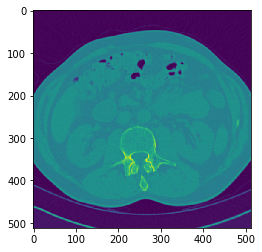

Cancer
0


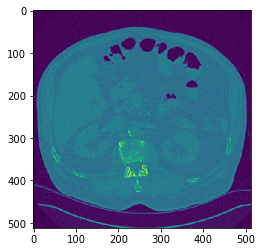

Cancer
1


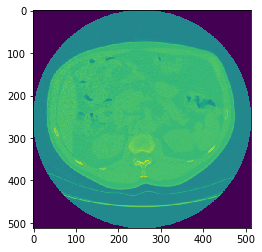

Cancer
0


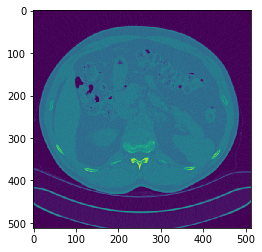

Cancer
0


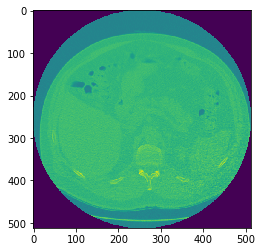

In [80]:
#####testing

for patient in patients:
    session =load_neural_net()
    printlabel(session,patient)
    
    
